#  Supervised learning addition model

Author: S. Menary [sbmenary@gmail.com]

Date: 31/3/2023  (last update: 4/4/2023)

Overview: Train a `sequence -> number` model where the input sequence is a text representation of a simple sum $A \pm B$ for integers $A,B\in\mathbb{Z}\left([-N,~N]\right)$ for some maximum-amplitude $N$, and the output is the answer. Since the output is a numerical value, the loss function is the mean squared error (MSE). This is equivalent to maximum-likelihood estimation assuming that the expected variance is the same for every datapoint (in fact this is true because the noise level is zero). Using MSE we obtain the estimator with the smallest variance out of all estimators with zero expected bias, assuming that the 'true' model lies within our hypothesis class.

---

## 1. Set up program

###  Import

All imports go here at the top of the notebook

In [1]:
##=========================##
##   All imports go here   ##
##=========================##

##  Import entire python stdlib packages
import datetime, json, logging, math, os, pickle, random, sys, time

##  Import entire pypi packages
import matplotlib as mpl
import numpy      as np
import tensorflow as tf

##  Import individual modules/objects from python stdlib packages
from pathlib import Path

##  Import individual modules/objects from pypi packages
from tensorflow.keras.callbacks  import Callback, CSVLogger, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers     import Average, Concatenate, Dense, Embedding, Input, Layer, Masking
from tensorflow.keras.models     import Model
from tensorflow.keras.optimizers import Adam
from matplotlib                  import pyplot as plt

##  Add directory above this to system path to expose mathsformer package location
sys.path.append("/".join(os.getcwd().split("/")[:-1]))

##  Import individual modules/objects from local packages
from mathsformer.data       import add_positions_to_sequences, detokenise_strings, strings_to_tensor, tokenise_strings
from mathsformer.tf_objects import (create_custom_objects_dict, AttentionBlock, EncoderBlock, FeedForwardBlock,
                                    LayerActivationRecord, LayerWeightsRecord, LoggerCallback, LossRecord,
                                    PositionalEncoding, ReduceSequence, RightSlice, get_nested_sublayers)
from mathsformer.utils      import create_working_directory, fancy_message, log_versions, summarise_dict


### Configuation

Set global configuration variables

In [2]:
##===================##
##   Global config   ##
##===================##


##  Set log levels for logging streams to notebook and to log file in working directory
log_lvl_iostream = logging.INFO
log_lvl_fstream  = logging.DEBUG


##  Create dictionary of config values
##  -  config values to be set here and never changed!
##  -  use nested dictionary as a proxy for namespacing
##  -  e.g. can access data config value like config["data"]["label_prescale"]
global_config = {
    "base_seed"         : -1,
    "working_directory" : "supervised_learning_addition_model_[tag]_[date]_[time]",
    "tag"               : "baseline",
    "data" : {
        "max_int"        : 1499,
        "label_prescale" : 1000,
        "char_tokens"    : ['M', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', 'N'],
        "mask_char"      : 'M',
        "seq_start_char" : '',
        "seq_end_char"   : '',
        "val_split_idx"  : 0.9,
        "test_split_idx" : 0.95,
        "dtype_data"     : "int32",
        "dtype_labels"   : "float32",
    },
    "model" : {
        "load_pretrained_model" : "",
        "ndim_model"            : 32,
        "ndim_embedding"        : 16,
        "num_freqs"             : 8,
        "min_period"            : 5,
        "max_period"            : 200,
        "num_pre_layers"        : 2,
        "ndim_pre_layers"       : 128,
        "num_encoding_layers"   : 6,
        "num_heads"             : 8,
        "ndim_att_hidden"       : 32,
        "ndim_ff_hidden"        : 64,
        "num_post_layers"       : 2,
        "ndim_post_layers"      : 128,
        "dropout"               : 0.1,
        "learning_rate"         : 1e-4,
        "dtype"                 : "float32"
    },
    "training" : {
        "train"                   : True,
        "max_epochs"              : 100,
        "batch_size"              : 32,
        "early_stopping"          : True,
        "early_stopping_patience" : 2,
        "layer_activation_record_batch_frequency" : 5000, 
        "layer_activation_record_max_datapoints"  : 128, 
        "layer_weights_record_batch_frequency" : 5000, 
        "layer_weights_record_recursive"       : True, 
        "loss_record_batch_frequency" : 5000, 
        "loss_record_max_datapoints"  : 256, 
        "loss_record_num_bootstrap"   : 20, 
    },
    "evaluate" : {
        "num_bootstrap" : 200,
        "num_print"     : 40,
    },
}


##  Report success
print(fancy_message(f"Created global_config"))

===   Created global_config   ===


###  Validate config

Look for some obvious confguration errors. WARNING: This is not an exhaustive search and can't be replied upon to catch all misconfigurations!

In [3]:
##===============================##
##   Global config - continued   ##
##===============================##

def validate_config(config) :
    """Raise exceptions in the case of program misconfigurations"""
    mask_char      = global_config["data"]["mask_char"]
    seq_start_char = global_config["data"]["seq_start_char"]
    seq_end_char   = global_config["data"]["seq_end_char"]
    char_tokens    = global_config["data"]["char_tokens"]
    
    ##  Check that only single character tokens are provided
    for char_token in char_tokens :
        if len(char_token) == 1 : continue
        raise ValueError(f"All character tokens must be single characters but '{char_tokens}' found")
        
    ##  Check that mask character is provided
    if len(mask_char) != 1 :
        raise ValueError(f"Mask character must be a single character but '{mask_char}' provided")
        
    ##  Check that mask character in character list
    if mask_char not in char_tokens :
        raise ValueError(f"Mask character '{mask_char}' not found in character list: {char_tokens}")
        
    ##  Check that seq_start_char character in character list if provided
    if len(seq_start_char) > 0 and seq_start_char not in char_tokens :
        raise ValueError(f"Sequence start character '{seq_start_char}' not found in character list: {char_tokens}")
        
    ##  Check that seq_end_char character in character list if provided
    if len(seq_end_char) > 0 and seq_end_char not in char_tokens :
        raise ValueError(f"Sequence end character '{seq_end_char}' not found in character list: {char_tokens}")
    
    ##  Check that mask character is first in char_tokens list (ensures it's assigned a token of 0)
    if char_tokens[0] != mask_char :
        raise ValueError(f"Mask character '{mask_char}' must be the first in the char_tokens list provided, "
                        +f"instead found list: {char_tokens}")
        
    ##  If here then config validated correctly
    print(fancy_message("Config successfully validated"))
    
validate_config(global_config)

===   Config successfully validated   ===


##  2. Set up environment

###  Create working directory


In [4]:
##==============================##
##   Create working directory   ##
##==============================##

##  Create working directory
working_dir = create_working_directory(global_config["working_directory"], tags=global_config)

##  Report success
print(fancy_message(f"Working directory created at {working_dir}"))


===   Working directory created at supervised_learning_addition_model_baseline_2023_04_04_215528   ===


###  Set up logging

- output stream to this notebook
- output stream to file in working directory

In [5]:
##=======================##
##   Configure logging   ##
##=======================##

##  Create stream to output log messages to stdout
iostream = logging.StreamHandler(sys.stdout)
iostream.setFormatter(logging.Formatter("%(levelname)7s  %(message)s"))
iostream.setLevel(log_lvl_iostream)

##  Create stream to output log messages to file
fstream = logging.FileHandler(f"{working_dir}/log.txt")
fstream.setFormatter(logging.Formatter("%(levelname)7s  %(message)s"))
fstream.setLevel(log_lvl_fstream)

##  Get root logger and add our stream handler
logger = logging.getLogger()
logger.addHandler(iostream)
logger.addHandler(fstream)
logger.setLevel(logging.DEBUG)

##  Log start time of 
logger.info(f"Begin logging on {datetime.datetime.today().strftime('%Y-%m-%d')} at {datetime.datetime.today().strftime('%H:%M:%S')}")


   INFO  Begin logging on 2023-04-04 at 21:55:28


###  Log package versions for reproducibility

In [6]:
##================================================##
##   Print package versions for reproducibility   ##
##================================================##

log_versions(logger, pull_from_sys=True, pull_submodules=True)   # [mpl, np, tf]

   INFO  ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO                                               PACKAGE  |  VERSION
   INFO  ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO                                                Python  |  3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
   INFO                                               IPython  |  8.7.0
   INFO                                  IPython.core.release  |  8.7.0
   INFO                                                   PIL  |  9.3.0
   INFO                                             PIL.Image  |  9.3.0
   INFO                                        PIL._deprecate  |  9.3.0
   INFO                                          PIL._version  |  9.3.0
   INFO                                              

   INFO                        setuptools._vendor.ordered_set  |  3.1
   INFO                          setuptools._vendor.packaging  |  21.3
   INFO                setuptools._vendor.packaging.__about__  |  21.3
   INFO                          setuptools._vendor.pyparsing  |  3.0.9
   INFO                     setuptools._vendor.more_itertools  |  8.8.0
   INFO                        setuptools._vendor.ordered_set  |  3.1
   INFO                          setuptools._vendor.packaging  |  21.3
   INFO                          setuptools._vendor.pyparsing  |  3.0.9
   INFO                                    setuptools.version  |  65.6.3
   INFO                                                   six  |  1.16.0
   INFO                                          socketserver  |  0.4
   INFO                                            stack_data  |  0.6.2
   INFO                                    stack_data.version  |  0.6.2
   INFO                                           tensorboard  |  2.11.

###  Log config values


In [7]:
##===============================##
##   Global config - continued   ##
##===============================##

##  Print config values
for config_str in summarise_dict(global_config) :
    logger.info(f"Registered global config value {config_str}")


   INFO  Registered global config value base_seed: -1
   INFO  Registered global config value working_directory: supervised_learning_addition_model_[tag]_[date]_[time]
   INFO  Registered global config value tag: baseline
   INFO  Registered global config value data > max_int: 1499
   INFO  Registered global config value data > label_prescale: 1000
   INFO  Registered global config value data > char_tokens: ['M', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', 'N']
   INFO  Registered global config value data > mask_char: M
   INFO  Registered global config value data > seq_start_char: 
   INFO  Registered global config value data > seq_end_char: 
   INFO  Registered global config value data > val_split_idx: 0.9
   INFO  Registered global config value data > test_split_idx: 0.95
   INFO  Registered global config value data > dtype_data: int32
   INFO  Registered global config value data > dtype_labels: float32
   INFO  Registered global config value model > load_pretrained_

### Initialise random seeds

Set the random seeds for base `python`, `numpy` and `tensorflow`.

In [8]:
##======================##
##   Set random seeds   ##
##======================##

##  Pull base_seed from global_config
base_seed = global_config["base_seed"]

##  If base_seed <= 0 then replace with current system time
if base_seed < 0 :
    logger.info(f"Updating base_seed from current value of {base_seed}")
    base_seed = int(time.time())
    logger.info(f"New base_seed is {base_seed}")
    
##  Set seed for python stdlib random
random.seed(base_seed)
logger.info(f"Python random seed set: {base_seed}")

##  Set seed for numpy random
np_seed = base_seed + 1
np.random.seed(np_seed)
logger.info(f"Numpy random seed set: {np_seed}")

##  Set seed for tf random
tf_seed = base_seed + 2
tf.random.set_seed(tf_seed)
logger.info(f"TensorFlow random seed set: {tf_seed}")


   INFO  Updating base_seed from current value of -1
   INFO  New base_seed is 1680641729
   INFO  Python random seed set: 1680641729
   INFO  Numpy random seed set: 1680641730
   INFO  TensorFlow random seed set: 1680641731


##  3. Create training data

###  Generate string-number pairs

In [9]:
##=====================##
##   Create raw data   ##
##=====================##

def generate_raw_dataset(max_int:int=999, scale:float=1., include_neg:bool=True, shuffle:bool=True) :
    '''
    Create dataset where input is str of "A+B" or "A-B", and output is float containing the answer
    A and B are positive or negative integers with maximum amplitude given
    The output is scaled to project it down to ~unity amplitude for stable training
    '''
    logger.info(f"generate_raw_dataset(): called with max_int={max_int:,}, include_neg={include_neg}, scale={scale}, shuffle={shuffle}")
    if include_neg : singles = np.arange(-max_int, max_int+1, dtype=np.int32) 
    else           : singles = np.arange(0       , max_int+1, dtype=np.int32)
    pairs   = np.array([[(x,y) for x in singles] for y in singles])
    pairs   = np.concatenate(pairs)
    summed  = pairs[:,0] + pairs[:,1]
    minus   = pairs[:,0] - pairs[:,1]
    dataset = []
    for (i1, i2), s, m in zip(pairs, summed, minus) :
        i1, i2 = f"{i1}".replace("-","N"), f"{i2}".replace("-","N")
        dataset.append((f"{i1}+{i2}", np.float32(s)/scale))     #  , f"{s}"))
        dataset.append((f"{i1}-{i2}", np.float32(m)/scale))     #  , f"{m}"))
    np.random.shuffle(dataset)
    logger.info(f"generate_raw_dataset(): created dataset with length {len(dataset):,}")
    return dataset


In [10]:
##=================================##
##   Create raw data - continued   ##
##=================================##

max_int        = global_config["data"]["max_int"]
label_prescale = global_config["data"]["label_prescale"]

start_time   = time.time()
raw_dataset  = generate_raw_dataset(max_int, scale=label_prescale)
max_X_length = max([len(s[0]) for s in raw_dataset])

logger.info(f"Created {len(raw_dataset):,} datapoints in {time.time()-start_time:.1f}s")
logger.info(f"Maximum input sequence length is {max_X_length}")


   INFO  generate_raw_dataset(): called with max_int=1,499, include_neg=True, scale=1000, shuffle=True
   INFO  generate_raw_dataset(): created dataset with length 17,988,002
   INFO  Created 17,988,002 datapoints in 35.5s
   INFO  Maximum input sequence length is 11


###   Process strings into fixed-length tokenised dataset with position indices

In [11]:
##=============================================##
##   Convert raw data to tokenised sequences   ##
##=============================================##

mask_char        = global_config["data"]["mask_char"]
char_tokens      = global_config["data"]["char_tokens"]
vocab_length     = len(char_tokens)
tokeniser_dict   = dict([(t,i) for i,t in enumerate(char_tokens)])
detokeniser_dict = dict([(i,t) for i,t in enumerate(char_tokens)])
mask_token       = tokeniser_dict[mask_char]

logger.info (f"Created tokens dictionaries with vocab_length={vocab_length}")
logger.debug(f"Tokeniser dictionary is {tokeniser_dict}")
logger.debug(f"Detokeniser dictionary is {detokeniser_dict}")

if mask_token != 0 :
    raise RuntimeError(f"Mask character {mask_char} with a token value {mask_token}, expected 0")
    

   INFO  Created tokens dictionaries with vocab_length=14


In [12]:
##=========================================================##
##   Convert raw data to tokenised sequences - continued   ##
##=========================================================##

dtype_data     = global_config["data"]["dtype_data"]
dtype_labels   = global_config["data"]["dtype_labels"]
seq_start_char = global_config["data"]["seq_start_char"]
seq_end_char   = global_config["data"]["seq_end_char"]

logger.info(f"Using mask character '{mask_char}'")
logger.info(f"Using sequence start character '{seq_start_char}'")
logger.info(f"Using sequence end character '{seq_end_char}'")

start_time = time.time()
data_X     = strings_to_tensor([x[0] for x in raw_dataset], 
                               tokeniser_dict, fix_output_length=max_X_length+len(seq_start_char)+len(seq_end_char), 
                               mask_char=mask_char, seq_start_char=seq_start_char, seq_end_char=seq_end_char, 
                               logger=logger, dtype=dtype_data)
data_Y     = tf.constant([[x[1]] for x in raw_dataset], dtype=dtype_labels)
logger.info(f"Data tensors created in {time.time()-start_time:.0f}s")


   INFO  Using mask character 'M'
   INFO  Using sequence start character ''
   INFO  Using sequence end character ''
   INFO  Data tensors created in 65s


###  Train/val/test split

In [13]:
##==================================##
##   Perform train/val/test split   ##
##==================================##


split_idx1 = int(global_config["data"]["val_split_idx" ]*len(data_X))
split_idx2 = int(global_config["data"]["test_split_idx"]*len(data_X))

train_X, train_Y = data_X[          :split_idx1], data_Y[          :split_idx1]
val_X  , val_Y   = data_X[split_idx1:split_idx2], data_Y[split_idx1:split_idx2]
test_X , test_Y  = data_X[split_idx2:          ], data_Y[split_idx2:          ]

logger.info(f"  Training data with shape {data_X.shape} and labels {data_Y.shape}")
logger.info(f"Validation data with shape { val_X.shape} and labels { val_Y.shape}")
logger.info(f"      Test data with shape {test_X.shape} and labels {test_Y.shape}")

   INFO    Training data with shape (17988002, 11, 2) and labels (17988002, 1)
   INFO  Validation data with shape (899400, 11, 2) and labels (899400, 1)
   INFO        Test data with shape (899401, 11, 2) and labels (899401, 1)


##  4.  Create model

In [14]:
##======================================##
##   Create supervised learning model   ##
##======================================##

def create_model(vocab_length:int, name=None, ndim_model:int=32, ndim_embedding:int=16, num_freqs:int=8, 
                 min_period:float=5, max_period:float=200, num_pre_layers:int=1, ndim_pre_layers:int=64, 
                 num_encoding_layers:int=3, num_heads:int=6, ndim_att_hidden:int=32, ndim_ff_hidden:int=64, 
                 num_post_layers:int=1, ndim_post_layers:int=64, dropout=0.1, learning_rate:float=0.001, 
                 dtype_in=tf.int32, dtype=tf.float32) :
    
    ##  Input layer - Shape [B, S, 2]
    x_in = Input((None,2), dtype=dtype_in, name=f"{name}_input_layer")
    
    ##  Pull out feature for token embedding
    x_embed = RightSlice(slice_index=0, newaxis=False, dtype=dtype, name=f"{name}_right_slice_token_ID")(x_in)
        
    ##  Token embedding - assuming input feature 0 is the token ID
    ##  Output shape [B, S, ndim_embedding]
    x_embed = Embedding(vocab_length, 
                        ndim_embedding, 
                        mask_zero=True, 
                        dtype=dtype, 
                        name=f"{name}_embedding")(x_embed)
    
    ##  Position encoding - assuming feature input 1 is the token index
    ##  -  Output shape [B, S, 2*num_freqs]
    x_pos = PositionalEncoding(slice_index=1, 
                               num_freqs=num_freqs, 
                               min_period=min_period, 
                               max_period=max_period, 
                               dtype=dtype, 
                               name=f"{name}_position_encoding")(x_in)
    
    ##  Combine embedding and position encoding by concatenation
    ##  - Output shape [B, S, ndim_embedding + 2*num_freqs]
    x = Concatenate(name=f"{name}_concat", dtype=dtype)([x_embed, x_pos])
    
    ##  If input to feed forward block is the same size as ndim_model then turn on skip_connect
    skip_connect = (ndim_model==x.shape[-1])
    logger.info(f"Pre-attention skip connection set to {skip_connect}")
    
    ##  Do initial pre-processing and collapse to model size
    ##  - use layer_norm instead of batch_norm because tokens in sequence are not independent
    x = FeedForwardBlock(ndim_model, 
                         ndim_hidden=ndim_pre_layers, 
                         num_hidden_layers=num_pre_layers, 
                         dropout=dropout, 
                         layer_norm=True, 
                         batch_norm=False,  
                         skip_connect=skip_connect, 
                         dtype=dtype, 
                         name =f"{name}_feedfwd_block_pre_attention")(x)
    
    ##  Run encoder blocks
    for layer_idx in range(num_encoding_layers) :
        x = EncoderBlock(ndim_model, 
                         num_heads, 
                         ndim_att_hidden, 
                         ndim_ff_hidden, 
                         dropout_mha=dropout, 
                         dtype=dtype, 
                         layer_norm=True, 
                         name=f"{name}_encoder_block_{layer_idx+1}")(x)
        
    ##  Contract over the sequence
    x = ReduceSequence(SUM=True, 
                       MEAN=True, 
                       STD=True, 
                       dtype=dtype, 
                       name=f"{name}_reduce_sequence")(x)
        
    ##  Collapse to model size
    x = FeedForwardBlock(1, 
                         ndim_hidden=ndim_post_layers, 
                         num_hidden_layers=num_post_layers, 
                         skip_connect=False, 
                         layer_norm=False, 
                         batch_norm=True, 
                         dtype=dtype, 
                         name=f"{name}_feedfwd_block_post_attention")(x)
    
    ##  Create model
    model = Model(x_in, x, name=name)
    
    ##  Compile model with MSE loss for supervised learning to numerical output
    model.compile(loss="mse", optimizer=Adam(learning_rate=learning_rate))
    
    ##  Return model
    return model
    

In [15]:
##==================================================##
##   Create supervised learning model - continued   ##
##==================================================##

model = create_model(vocab_length        = vocab_length, 
                     name                = "supervised_learning_mse",
                     ndim_model          = global_config["model"]["ndim_model"],
                     ndim_embedding      = global_config["model"]["ndim_embedding"],
                     num_freqs           = global_config["model"]["num_freqs"],
                     min_period          = global_config["model"]["min_period"],
                     max_period          = global_config["model"]["max_period"],
                     num_pre_layers      = global_config["model"]["num_pre_layers"],
                     ndim_pre_layers     = global_config["model"]["ndim_pre_layers"],
                     num_encoding_layers = global_config["model"]["num_encoding_layers"],
                     num_heads           = global_config["model"]["num_heads"],
                     ndim_att_hidden     = global_config["model"]["ndim_att_hidden"],
                     ndim_ff_hidden      = global_config["model"]["ndim_ff_hidden"],
                     num_post_layers     = global_config["model"]["num_post_layers"],
                     ndim_post_layers    = global_config["model"]["ndim_post_layers"],
                     dropout             = global_config["model"]["dropout"],
                     learning_rate       = global_config["model"]["learning_rate"],
                     dtype_in            = global_config["data" ]["dtype_data"],
                     dtype               = global_config["model"]["dtype"],)

logging.info("Model created with summary:")
model.summary(print_fn=logging.info)


   INFO  Pre-attention skip connection set to True
   INFO  Model created with summary:
   INFO  Model: "supervised_learning_mse"
   INFO  __________________________________________________________________________________________________
   INFO   Layer (type)                   Output Shape         Param #     Connected to                     
   INFO  ==================================================================================================
   INFO   supervised_learning_mse_input_  [(None, None, 2)]   0           []                               
   INFO   layer (InputLayer)                                                                               
   INFO                                                                                                    
   INFO   supervised_learning_mse_right_  (None, None)        0           ['supervised_learning_mse_input_l
   INFO   slice_token_ID (RightSlice)                                     ayer[0][0]']                     
   INF

In [16]:
##====================================##
##   Load supervised learning model   ##
##====================================##
    
##  Get load model name
load_model = global_config["model"]["load_pretrained_model"]

##  Load model
if load_model :
    logger.info(f"Loading model from file '{load_model}'")
    logger.warning("Loading model will replace model configuration - check to make sure the following summary is what you expect!")
    model = tf.keras.models.load_model(load_model, custom_objects=create_custom_objects_dict(model=model))
    logging.info("Model loaded with summary:")
    model.summary(print_fn=logging.info)


##  5.  Train model

In [17]:
##===================================##
##   Create callbacks for training   ##
##===================================##


##  Create list of training callbacks
callbacks = []


##  Add logger callback
logger.info("Registering training callback: LoggerCallback with DEBUG log-level")
callbacks.append(LoggerCallback(logger, loglvl=logging.DEBUG))


##  Add callback for early stopping
if global_config["training"].get("early_stopping", True) :
    monitor, restore_best_weights = "val_loss", True
    patience = global_config["training"].get("early_stopping_patience", 1)
    logger.info(f"Registering training callback: EarlyStopping with monitor={monitor}, patience={patience}, restore_best_weights={restore_best_weights}")
    callbacks.append(EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=restore_best_weights))
    
    
## Add callback for model checkpointing
if global_config["training"].get("model_checkpoint", True) :
    filepath = working_dir+"/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5"
    logger.info(f"Registering training callback: ModelCheckpoint with filepath={filepath}")
    callbacks.append(ModelCheckpoint(filepath=filepath))

    
##  Add callback to intermittently record loss over small subset of validation data
batch_frequency = global_config.get("training").get("loss_record_batch_frequency", 1000)
max_datapoints  = global_config.get("training").get("loss_record_max_datapoints" , 2048)
num_bootstrap   = global_config.get("training").get("loss_record_num_bootstrap"  , 10)
loss_record = LossRecord(
    batch_frequency = batch_frequency, 
    val_input       = val_X[:max_datapoints], 
    val_output      = val_Y[:max_datapoints],
    num_bootstrap   = num_bootstrap,
)
logger.info(f"Registering training callback: LossRecord with batch_frequency={batch_frequency}, max_datapoints={max_datapoints}, num_bootstrap={num_bootstrap}")
callbacks.append(loss_record)

    
##  Add callback to intermittently record layer activations
##  -  Since sublayers are not tracked by the computational graph, we cannot access sublayer.output within 
##     a keras function, and therefore we cannot track the activations of sublayers as we may wish
batch_frequency = global_config.get("training").get("layer_activation_record_batch_frequency", 1000)
max_datapoints  = global_config.get("training").get("layer_activation_record_max_datapoints" , 128)
layer_activation_record = LayerActivationRecord(
    batch_frequency = batch_frequency, 
    val_input       = val_X[:max_datapoints], 
)
logger.info(f"Registering training callback: LayerActivationRecord with batch_frequency={batch_frequency}, max_datapoints={max_datapoints}")
callbacks.append(layer_activation_record)


##  Add callback to intermittently record layer weights - use recursive=True to monitor all sublayers
batch_frequency = global_config.get("training").get("layer_weights_record_batch_frequency", 1000)
recursive       = global_config.get("training").get("layer_weights_record_recursive"      , True)
layer_weights_record = LayerWeightsRecord(
    batch_frequency = batch_frequency, 
    recursive       = recursive
)
logger.info(f"Registering training callback: LayerWeightsRecord with batch_frequency={batch_frequency}, recursive={recursive}")
callbacks.append(layer_weights_record)


   INFO  Registering training callback: LoggerCallback with DEBUG log-level
   INFO  Registering training callback: EarlyStopping with monitor=val_loss, patience=2, restore_best_weights=True
   INFO  Registering training callback: ModelCheckpoint with filepath=supervised_learning_addition_model_baseline_2023_04_04_215528/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5
   INFO  Registering training callback: LossRecord with batch_frequency=5000, max_datapoints=256, num_bootstrap=20
   INFO  Registering training callback: LayerActivationRecord with batch_frequency=5000, max_datapoints=128
   INFO  Registering training callback: LayerWeightsRecord with batch_frequency=5000, recursive=True


In [18]:
##=====================================##
##   Train supervised learning model   ##
##=====================================##


##  Fit the model if configured
if global_config.get("training",{}).get("train",True) :
    max_epochs = global_config["training"]["max_epochs"]
    batch_size = global_config["training"]["batch_size"]
    
    logger.info(f"Begin model training with max_epochs={max_epochs}, batch_size={batch_size}")
    model.fit(train_X, 
              train_Y,
              epochs          = max_epochs,
              batch_size      = batch_size,
              validation_data = (val_X, val_Y),
              callbacks       = callbacks
             )
else :
    logger.warning("Skipping model training following global config instructions")


   INFO  Begin model training with max_epochs=100, batch_size=32
Epoch 1/100


2023-04-04 21:57:09.975694: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


     6/505913 [..............................] - ETA: 3:19:03 - loss: 3.7645WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0229s vs `on_train_batch_end` time: 0.0310s). Check your callbacks.
WARNING  Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0229s vs `on_train_batch_end` time: 0.0310s). Check your callbacks.
505913/505913 [==============================] - 16699s 33ms/step - loss: 0.0531 - val_loss: 3.1954e-04
Epoch 2/100
505913/505913 [==============================] - 18048s 36ms/step - loss: 0.0457 - val_loss: 3.3306e-04
Epoch 3/100
 69664/505913 [===>..........................] - ETA: 4:44:21 - loss: 0.0457

KeyboardInterrupt: 

## 6.  Evaluate model

In [19]:
##========================================##
##   Evaluate supervised learning model   ##
##========================================##


##  Get predictions over test dataset
logger.info(f"Computing predictions for {len(test_X)} test datapoints")
start_time  = time.time()
test_pred_Y = model(test_X, training=False)
logger.info(f"Predictions computed in {time.time()-start_time:.1f}s")

##  Get baseline loss over test dataset
logger.info(f"Computing test loss")
start_time  = time.time()
baseline_loss = model.compute_loss(y=test_Y, y_pred=test_pred_Y)
logger.info(f"Test loss is {baseline_loss}, computed in {time.time()-start_time:.1f}s")

##  Bootstrap the loss to find its variance
num_bootstrap  = int(global_config.get("evaluate",{}).get("num_bootstrap", 1000))
sample_weights = tf.random.poisson((num_bootstrap, test_pred_Y.shape[0]), 1)
bootstrap_losses = []
for sample_weight in sample_weights :
    bootstrap_loss = model.compute_loss(y=test_Y, y_pred=test_pred_Y, sample_weight=sample_weight)
    bootstrap_loss = bootstrap_loss.numpy() * len(sample_weight) / sample_weight.numpy().sum()
    bootstrap_losses.append(bootstrap_loss)
    
##  Report result
logger.info(f"Bootstrapped test loss is {np.mean(bootstrap_losses):.6f} +- {np.std(bootstrap_losses):.6f}")


   INFO  Computing predictions for 899401 test datapoints


KeyboardInterrupt: 

In [20]:
##====================================================##
##   Evaluate supervised learning model - continued   ##
##====================================================##

##  Find out how many datapoints to print predictions for 
num_print = int(global_config.get("evaluate",{}).get("num_print", 20))

##  Log table header
logger.info("Evaluating text --> number model on the test set:\n")
logger.info("INPUT TEXT".rjust(14) + "TRUE VAL".rjust(14) + "PRED VAL".rjust(14) + "RESIDUAL".rjust(14))
logger.info("-"*60)

##  Get model predictions and log alongside true labels 
for x, true_y, pred_y in zip(detokenise_strings(test_X[:num_print,:,0].numpy(), 
                                                detokeniser_dict, mask_char=mask_char, 
                                                seq_start_char=seq_start_char, seq_end_char=seq_end_char), 
                             label_prescale*test_Y[:num_print,0].numpy(), 
                             label_prescale*model(test_X[:num_print])[:,0].numpy()) :
    logger.info(x.rjust(14) + f"{true_y:.2f}".rjust(14) + f"{pred_y:.2f}".rjust(14) + f"{pred_y-true_y:.2f}".rjust(14))


   INFO  Evaluating text --> number model on the test set:

   INFO      INPUT TEXT      TRUE VAL      PRED VAL      RESIDUAL
   INFO  ------------------------------------------------------------
   INFO        910-N784       1694.00       1691.73         -2.27
   INFO         629+752       1381.00       1378.81         -2.19
   INFO       N1088+699       -389.00       -389.47         -0.47
   INFO      N206-N1287       1081.00       1058.31        -22.69
   INFO      1320+N1346        -26.00        -44.62        -18.62
   INFO        1314-486        828.00        826.08         -1.92
   INFO        N991-N86       -905.00       -914.92         -9.92
   INFO        736-N421       1157.00       1147.87         -9.13
   INFO       N1140+450       -690.00       -689.17          0.83
   INFO        N757+784         27.00         26.63         -0.37
   INFO       821-N1495       2316.00       2289.72        -26.28
   INFO       1367+N642        725.00        704.18        -20.82
   INFO     

##  7. Additional visualisations

   INFO  Plotting training loss curve


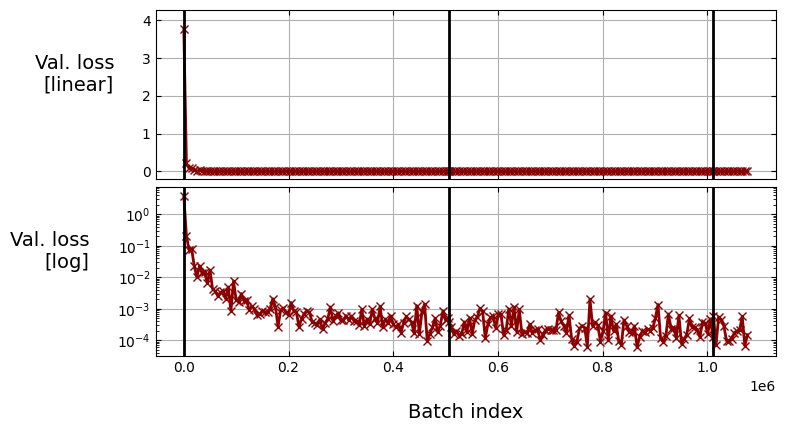

In [21]:
##====================================##
##   Visualise loss during training   ##
##====================================##

if len(loss_record.val_loss) == 0 :
    logger.warning("Not plotting training loss curve because no data found")
else :
    logger.info("Plotting training loss curve")
    
    fig = plt.figure(figsize=(8, 4.5))
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    ax1 = fig.add_subplot(2, 1, 1)
    ax1.tick_params(axis="both", which="both", top=True, right=True, direction="in")
    ax1.grid()

    ax1.xaxis.set_ticklabels([])
    ax1.set_ylabel("Val. loss\n[linear]", ha="right", fontsize=14, labelpad=20, rotation=0)

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.tick_params(axis="both", which="both", top=True, right=True, direction="in")
    ax2.grid()

    ax2.set_ylabel("Val. loss\n[log]", ha="right", fontsize=14, labelpad=20, rotation=0)
    ax2.set_xlabel("Batch index", va="top", fontsize=14, labelpad=20)

    x, y, yerr = loss_record.batch_indices, loss_record.val_loss, loss_record.val_loss_std
    x, y, yerr = np.array(x), np.array(y), np.array(yerr)
    ax1.plot(x, y, "x-", lw=2, c="darkred")
    ax2.plot(x, y, "x-", lw=2, c="darkred")
    if len(yerr) :
        ax1.fill_between(x, y-yerr, y+yerr, lw=0, fc="darkred", alpha=0.3)
        ax2.fill_between(x, y-yerr, y+yerr, lw=0, fc="darkred", alpha=0.3)
    ax2.set_yscale("log")
    
    epoch_transition = -0.5
    while epoch_transition < layer_activation_record.batch_indices[-1] :
        ax1.axvline(epoch_transition, ls="-", lw=2, c="k")
        ax2.axvline(epoch_transition, ls="-", lw=2, c="k")
        epoch_transition += layer_activation_record.num_steps
    
    plt.show(fig)
    

In [22]:
##=========================================================================##
##   Quick function for plotting the data stored in our custom callbacks   ##
##=========================================================================##

def plot_tracks(record, y_label, num_col=3) :
    layer_names = [layer_name for layer_name, layer_mean in record.layer_means.items() if len(layer_mean) > 0]
    layer_names = sorted(layer_names)
    
    num_row = math.ceil(len(layer_names) / num_col)

    fig = plt.figure(figsize=(4*num_col, 4*num_row))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for layer_idx, layer_name in enumerate(layer_names) :

        ax  = fig.add_subplot(num_row, num_col, 1+layer_idx)
        ax.tick_params(which="both", axis="both", direction="in", left=True, top=True, labelsize=8)
        ax.set_title(layer_name, fontsize=6)

        x  = np.array(record.batch_indices)
        y  = np.array(record.layer_means[layer_name])
        ey = np.array(record.layer_stds [layer_name])

        if not len(y) : continue

        ax.plot(x, y, "-", lw=3, c='k')
        ax.fill_between(x, y-ey, y+ey, fc="darkblue", alpha=0.2, lw=0)
        
        if layer_idx == 0 :
            ax.text(0, 1.2, f"{y_label} vs batch index", weight="bold", ha="left", 
                    va="bottom", fontsize=16, transform=ax.transAxes)

    plt.show(fig)
    

   INFO  Plotting layer activations


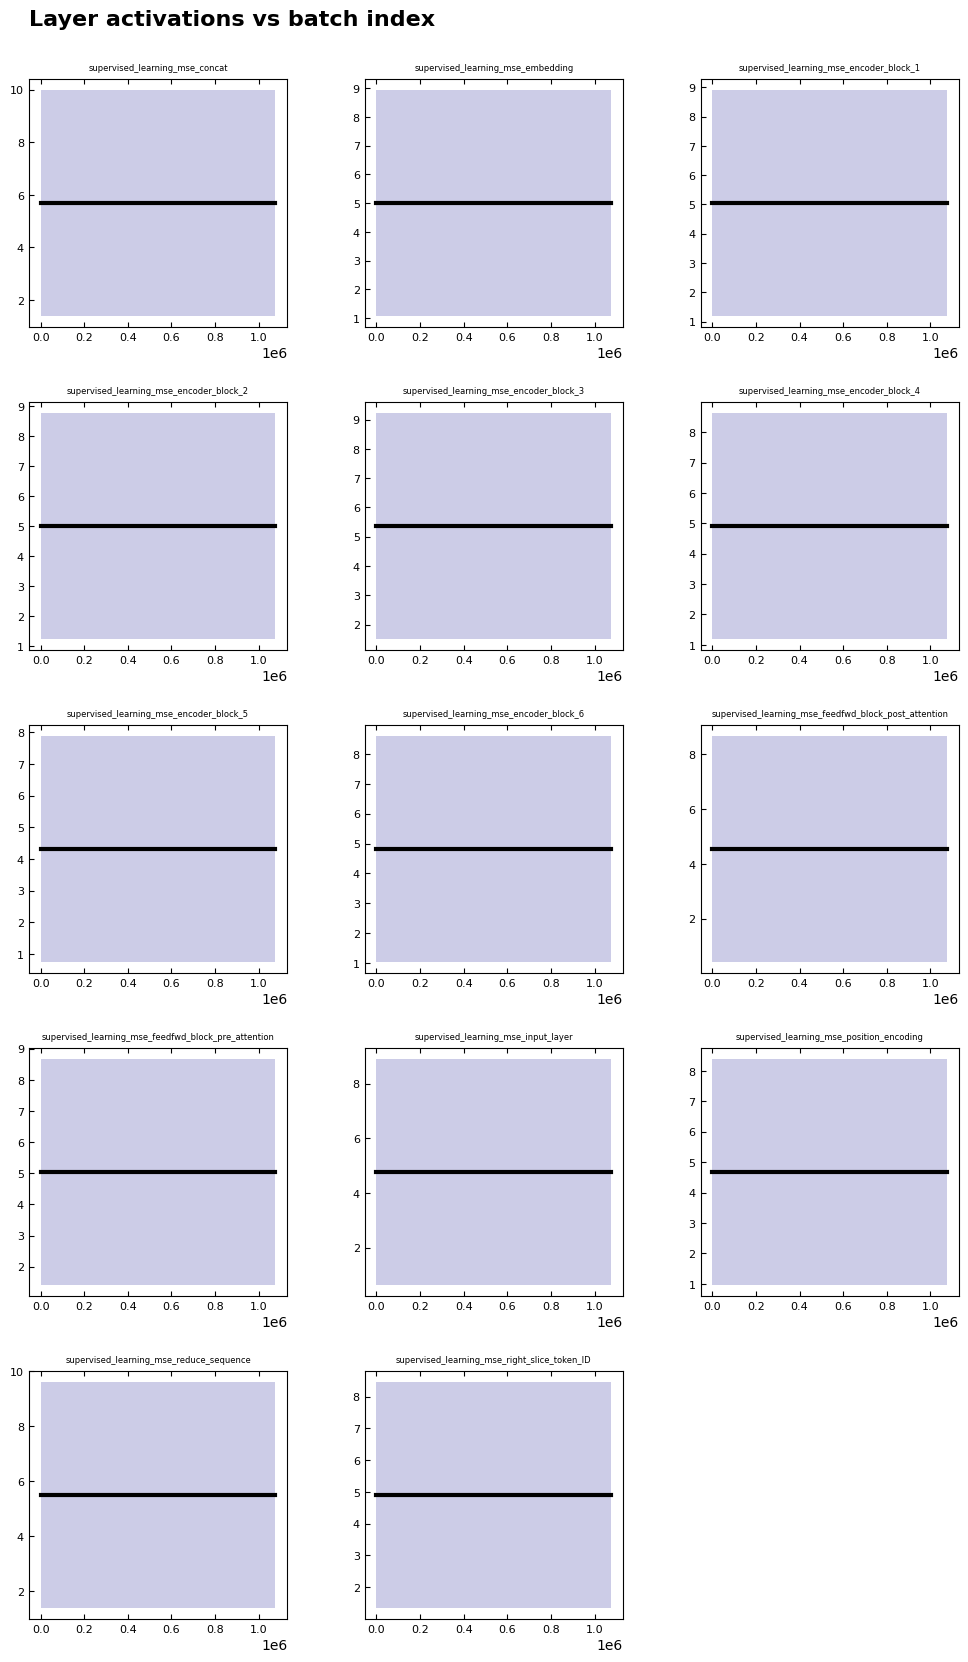

In [23]:
##=================================================##
##   Visualise layer activations during training   ##
##=================================================##

if len(layer_activation_record.batch_indices) == 0 :
    logger.warning("Not plotting layer activations because no data found")
else :
    logger.info("Plotting layer activations")
    plot_tracks(layer_activation_record, "Layer activations", num_col=3)
    

   INFO  Plotting layer weights


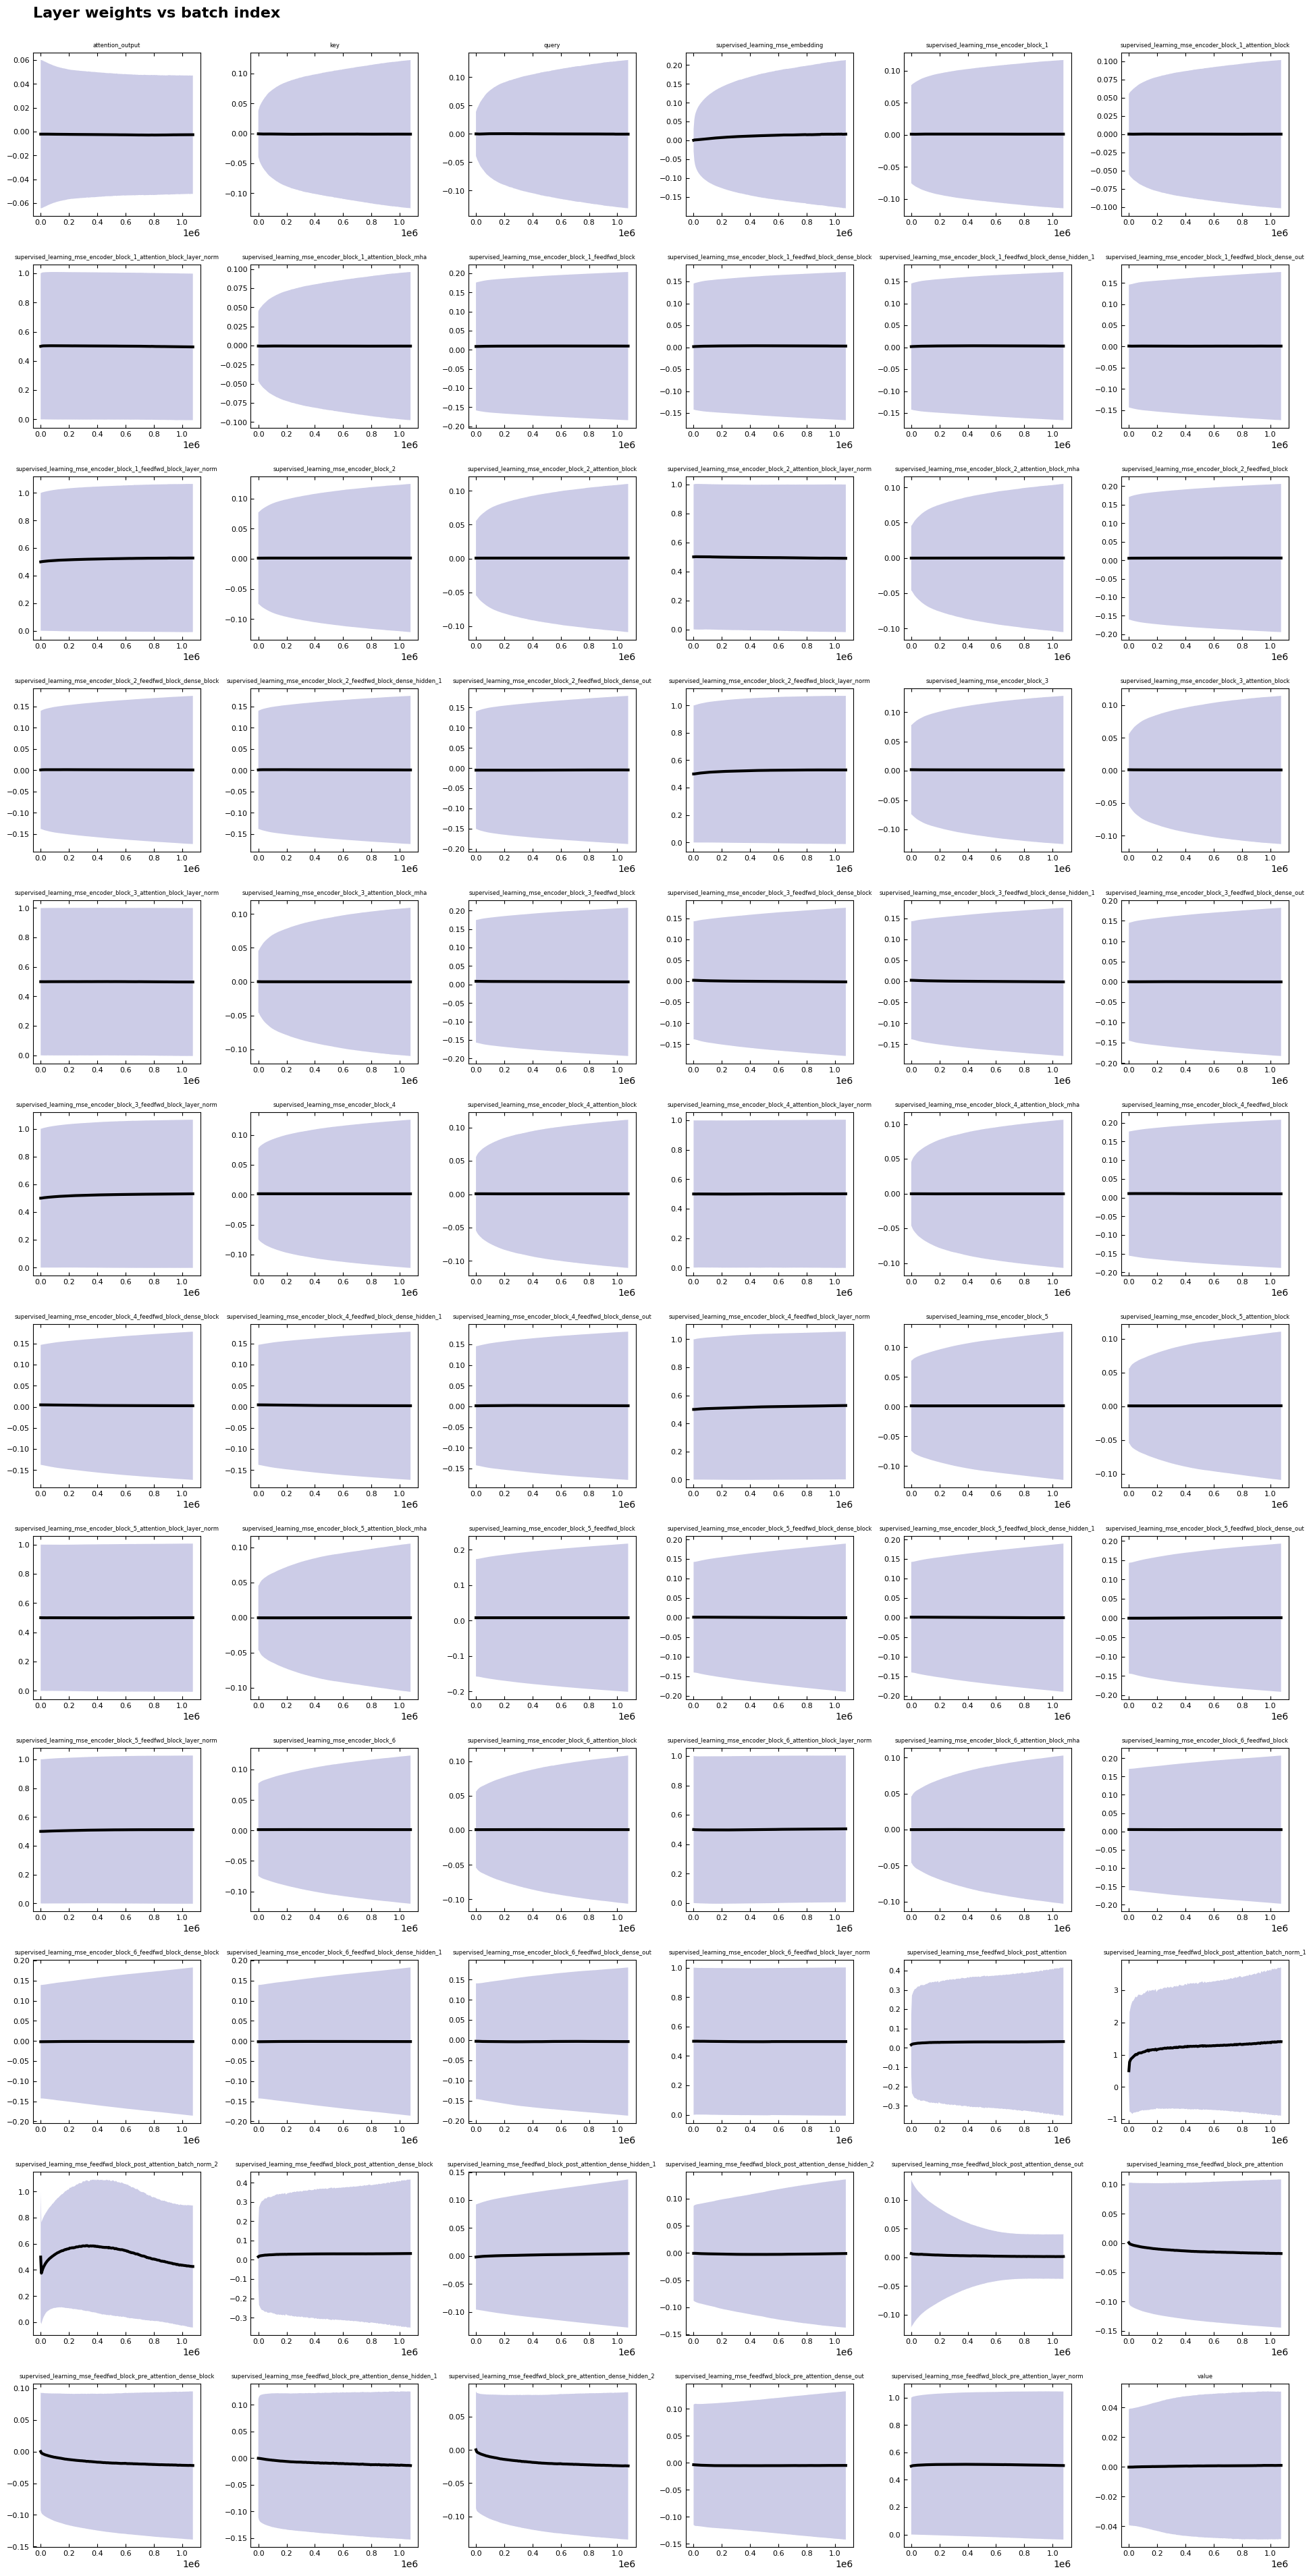

In [24]:
##=============================================##
##   Visualise layer weights during training   ##
##=============================================##

if len(layer_weights_record.batch_indices) == 0 :
    logger.warning("Not plotting layer weights because no data found")
else :
    logger.info("Plotting layer weights")
    plot_tracks(layer_weights_record, "Layer weights", num_col=6)
    